## Dimensionality reduction on molecular fingerprints for chemical space representation

After answering a question on the RDKit mailing list, I was warned that PCA might not be an appropriate dimensionality reduction method to apply on molecular fingerprints. 

This is well explained in [this paper](https://link.springer.com/article/10.1007/s10822-014-9819-y). It turns out that:
> *distances from PCA on bit vectors are proportional to the square root of Hamming distance.*

However, Hamming distances give equal weights to bits that are both 0 or both 1 for a pair of molecules, that is, sharing the same molecular feature contributes to an increased similarity value as much as not sharing a certain feature. The authors relate this to the [raven paradox](https://en.wikipedia.org/wiki/Raven_paradox), which those who have studied about the scientific method may recall.

Philosophical discussions apart, the authors suggest that, in general, we are more interested in classifying molecules that **share** chemical features as similar. Therefore, instead of PCA, an MDS (multidimensional scaling) graph calculated using a distance matrix (using Tanimoto indexes) might be a more appropriate way to describe the chemical space using fingerprints.

Since the original paper has not provided code, in this notebook, I will try to reproduce this MDS graph in Python.

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
from sklearn import manifold

The paper provides a [list of boronic acids](https://static-content.springer.com/esm/art%3A10.1007%2Fs10822-014-9819-y/MediaObjects/10822_2014_9819_MOESM1_ESM.pdf) that was used to represent a chemical space, which I have copied as a .txt file.

In [2]:
# Import list of molecular structures as SMILES
smi = pd.read_csv("boronic_acids.txt", skiprows=list(range(11)))
smi.columns=["SMILES"]
smi.head()

,SMILES
0,CB(O)O
1,CCB(O)O
2,CCCB(O)O
3,OB(O)C1CC1
4,CCCCCB(O)O


In [3]:
# Calculate fingerprints
mol = [Chem.MolFromSmiles(m) for m in smi["SMILES"]]
fps = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 3, 2048) for m in mol]

In [4]:
# Calculate distance matrix
# Note that this already computes the distance, which is 1 - Tanimoto index
# That is, similar molecules will have a distance value close to zero
mat_1d = GetTanimotoDistMat(fps)
mat_1d

array([0.63636364, 0.71428571, 0.5       , ..., 0.77108434, 0.83870968,
       0.83673469])

RDKit outputs the distance values as a 1-D array of the lower triangular matrix. To use MDS, we need the full square distance matrix

In [5]:
def square_distance_matrix(a):
    # https://stackoverflow.com/questions/51439271/convert-1d-array-to-lower-triangular-matrix
    # https://stackoverflow.com/questions/36250729/how-to-convert-triangle-matrix-to-square-in-numpy
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n, dtype=bool, k=-1)
    tr = np.zeros((n,n), dtype=float)
    tr[mask] = a  # fills lower triangular matrix
    return np.triu(tr.T,1) + tr  # fills upper part - MDS requires symmetrical matrix

In [6]:
dist_mat = square_distance_matrix(mat_1d)

In [7]:
# Generate MDS graph
# If you pass dissimilarity='precomputed', MDS takes a dissimilarity matrix.
mds = manifold.MDS(n_components=2, metric=False, max_iter=200, n_init=10, dissimilarity='precomputed', random_state=0)
mds_coords = mds.fit_transform(dist_mat)

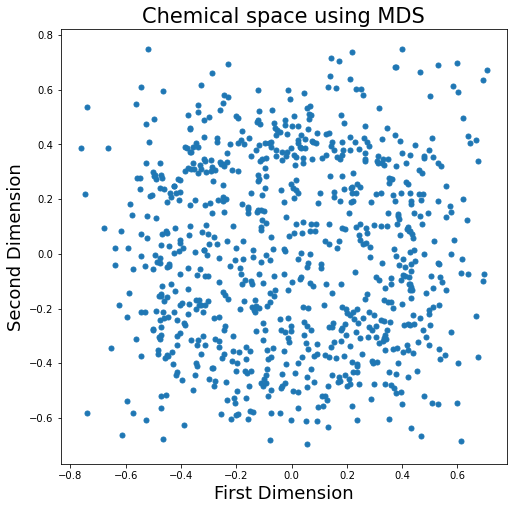

In [8]:
# Plot
# https://medium.com/dataseries/multidimensional-scaling-for-dissimilarity-visualization-9fb061396cf3

plt.figure(figsize=(8,8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], s=25)

# # Use this in case you want labels on the points
# mol_labels = ["mol1", "mol2", "mol3"]
# for label, x, y in zip(mol_labels, mds_coords[:,0], mds_coords[:,1]):
#     plt.annotate(label, (x,y), xycoords = 'data')

plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.title('Chemical space using MDS', fontsize=21)    
plt.show()

In [9]:
# Calculate distances from MDS graph
mds_distances = []
for i in range(len(mds_coords)):
    for j in range(i+1, len(mds_coords)):
        mds_distances.append(np.linalg.norm(mds_coords[i] - mds_coords[j]))  # Euclidean distance  

In [10]:
from sklearn.metrics import mean_squared_error

# Calculate RMSD between original (Tanimoto) distances and MDS distances
rms = mean_squared_error(mat_1d, mds_distances, squared=False)
print("RMSD between Tanimoto and MDS distances:", rms.round(3))

RMSD between Tanimoto and MDS distances: 0.395


The RMSD reported on the paper is 0.45

If you play with the hyperparameters of MDS, you can get different results. For instance, setting `metric=True` can generate a more symmetrical graph, with two apparent clusters, but I'm not sure if this reflects something about the dataset or if it is just an artifact.

In [11]:
# Generate MDS graph - metric=True
# If you pass dissimilarity='precomputed', MDS takes a dissimilarity matrix.
mds = manifold.MDS(n_components=2, metric=True, max_iter=100, n_init=1, dissimilarity='precomputed', random_state=0)
mds_coords = mds.fit_transform(dist_mat)

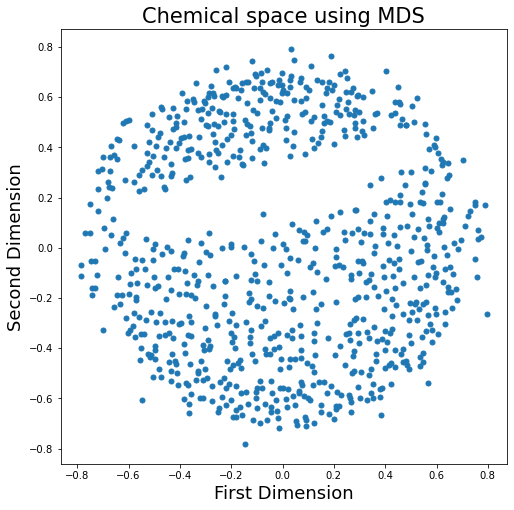

In [12]:
# Plot
plt.figure(figsize=(8,8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], s=25)
plt.xlabel('First Dimension', fontsize=18)
plt.ylabel('Second Dimension', fontsize=18)
plt.title('Chemical space using MDS', fontsize=21)    
plt.show()

In [13]:
# Calculate distances from MDS graph
mds_distances = []
for i in range(len(mds_coords)):
    for j in range(i+1, len(mds_coords)):
        mds_distances.append(np.linalg.norm(mds_coords[i] - mds_coords[j]))  # Euclidean distance  

In [14]:
from sklearn.metrics import mean_squared_error

# Calculate RMSD between original (Tanimoto) distances and MDS distances
rms = mean_squared_error(mat_1d, mds_distances, squared=False)
print("RMSD between Tanimoto and MDS distances:", rms.round(3))

RMSD between Tanimoto and MDS distances: 0.376
